In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
import random
from collections import defaultdict

In [46]:
import requests
import json

def smallworldscore(word):
    url = f"https://smallworldofwords.org/search/en/dictionary/all/{word}/click"
    word_stats = json.loads(requests.get(url).text)
    return word_stats

In [47]:
class WordTable():

    def __init__(self, wordlist):
        self.score = defaultdict(int)
        self.SWS = defaultdict(lambda: defaultdict(int))
        for word in wordlist:
            self.score[word] = 0
        
    def resetScore(self):
        self.score = self.score.fromkeys(self.score, 0)

    def buildSWS(self):
        for word in self.score:
            sws_tree = smallworldscore(word)
            forward = sws_tree['forward']
            backward = sws_tree['backward']

            for score in forward + backward:
                self.SWS[word][score['word']] = score['freq']
            
    def assocScore(self, related_word):
        for word in self.score:
            self.score[word] += self.SWS[word][related_word]

    def plot(self, size = 5):
        np_values = np.array(list(self.score.values()))
        np_keys = np.array(list(self.score.keys()))

        np_values = np_values.reshape(size, size)
        np_keys = np_keys.reshape(size, size)

        ax = plt.figure(figsize=(14, 11))
        df = pd.DataFrame(np_values)
        annot = [["{}\n{}".format(np_keys[i][j], np_values[i][j]) for j in range(size)] for i in range(size)]
        ax = sns.heatmap(df, annot=annot, fmt ='', annot_kws={'size' : 10})

In [48]:
wordtable = WordTable(['bagel', 'donut', 'apple', 'carrot'])
wordtable.buildSWS()

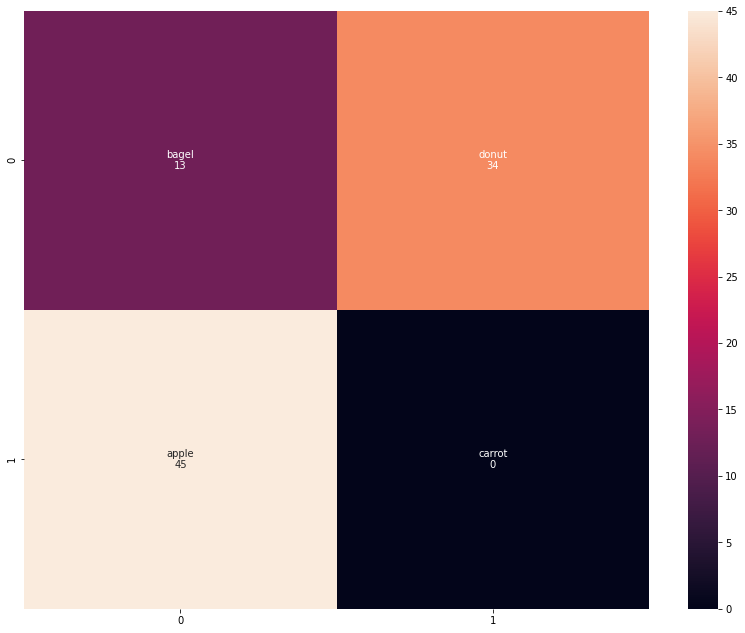

In [49]:
wordtable.resetScore()
wordtable.assocScore('hole')
wordtable.assocScore('fruit')
wordtable.plot(size = 2)
